In [2]:
pip install imblearn

  Using cached scikit_learn-1.1.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pysal 2.4.0 requires urllib3>=1.26, but you have urllib3 1.25.11 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install minisom

Note: you may need to restart the kernel to use updated packages.


In [4]:
# https://github.com/JustGlowing/minisom

In [5]:
pip install tslearn

Note: you may need to restart the kernel to use updated packages.


In [6]:
# https://tslearn.readthedocs.io/en/stable/index.html

In [7]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [8]:
! pip install tslearn
! pip uninstall scikit-learn --yes 
! pip install scikit-learn==0.24.1

Found existing installation: scikit-learn 1.1.2
Uninstalling scikit-learn-1.1.2:
  Successfully uninstalled scikit-learn-1.1.2
  Using cached scikit_learn-0.24.1-cp39-cp39-manylinux2010_x86_64.whl (23.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pysal 2.4.0 requires urllib3>=1.26, but you have urllib3 1.25.11 which is incompatible.
imbalanced-learn 0.9.1 requires scikit-learn>=1.1.0, but you have scikit-learn 0.24.1 which is incompatible.


In [9]:
! pip install rfpimp -q

In [10]:
# Native libraries
import os
import math
import warnings

# Essential Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from tqdm.autonotebook import tqdm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupKFold, cross_val_predict
import statsmodels.api as sm


warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

SEED=23


/tmp/ipykernel_3244/2043493672.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [11]:
s_2 = pd.read_csv('3_future_count_complete.csv')
cluster_label = pd.read_csv('4_time_series_clusters_label.csv')
#time_feature_label = pd.read_csv('4_time_weekday_month_clustering.csv')
time_feature_cluster = pd.read_csv('4_time_feature_clustering.csv')
time_high_frequency = pd.read_csv('4_time_highfrequency.csv')
time_feature_cluster_NOT_DUMMY = pd.read_csv('4_time_feature_NOT_DUMMY.csv')

s_2 = s_2.merge(cluster_label, right_on = 'LSOA',left_on = 'LSOA_2011_Name')
#s_2 = s_2.merge(time_feature_label[['KMeans']], left_index = True, right_index = True)
s_2 = s_2.merge(time_high_frequency , left_index = True, right_index = True)
s_2 = s_2.merge(time_feature_cluster_NOT_DUMMY , left_index = True, right_index = True)
s_2 = s_2.drop(columns = ['Unnamed: 0_y'])

In [12]:
s_2

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,index,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
0,0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1,10418,10418,11375,NC11376,15,10/29/2018,2018/19,Burglar/fire alarm,Noise Complaint,...,0,Westminster 018C,1,0,0,1,3,0,1,1
2,2,66,66,68,NC69,6,4/3/2018,2018/19,Burglar/fire alarm,Noise Complaint,...,0,Westminster 018C,2,0,0,1,3,0,1,1
3,3,84,84,90,NC91,20,4/3/2018,2018/19,Busker complaint,Noise Complaint,...,0,Westminster 018C,3,0,0,1,3,0,1,1
4,4,198,198,213,NC214,20,4/6/2018,2018/19,Busker complaint,Noise Complaint,...,0,Westminster 018C,4,0,0,1,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83736,83736,68145,68145,73797,NC73798,1,7/24/2021,2021/22,Residential noise,Noise Complaint,...,0,Westminster 024E,90793,0,0,1,4,4,1,0
83737,83737,68504,68504,74179,NC74180,13,7/30/2021,2021/22,Noise in the street,Noise Complaint,...,0,Westminster 024E,90794,0,0,1,4,4,1,0
83738,83738,68792,68792,74486,NC74487,9,8/4/2021,2021/22,Building site,Noise Complaint,...,0,Westminster 024E,90795,0,0,1,4,4,1,0
83739,83739,74441,74441,80518,NC80519,20,11/1/2021,2021/22,Residential noise,Noise Complaint,...,0,Westminster 024E,90796,0,0,1,4,4,1,0


In [13]:
s_2 = s_2.sort_values(by ='index').set_index('index').loc[0:88298]
s_2


,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [14]:
s_2.to_csv('4_0717_record.csv')

In [15]:
for i in s_2 .columns:
    print(i +',')

Unnamed: 0_x,
Unnamed: 0.1,
Unnamed: 0.1.1,
Noise_Complaint_Index,
Time,
Received_Date,
Financial_Year,
Service_Request,
Service_Request_Group_Type,
Service_Request_Group_Sub_Type,
Service_Request_1,
Address_Key_,
Type_of_Address,
Output_Area_Code_(2011),
MSOA_2011_Code,
MSOA_2011_Name,
LSOA_2011_Code,
LSOA_2011_Name,
Ward_Name,
Date,
Days,
Year_Month,
Year_Week,
Year,
Month,
Weekday,
Season,
days,
is_repeat_2days,
is_repeat_7days,
is_repeat_30days,
2days_count,
7days_count,
30days_count,
bef_todays_count,
bef_yesterday_count,
bef_2_7days_count,
bef_7_30days_count,
bef_30_365days_count,
bef_365_begindays_count,
is_repeat_2_7days,
is_repeat_7_30days,
top5_lsoa_count,
LSOA_Count,
top5_address_count,
Adress_Count,
LSOA11CD,
cluster0,
cluster1,
cluster2,
is_high_hour,
is_high_weekday,
is_high_month,
is_lock_down,
Building Site,
Commercial Premises,
Email Complaint (1d),
Non Noise Complaint (45m),
Property Alarm,
Residential Premises,
Street,
year_month_cl_0,
year_month_cl_1,
year_month_cl_

In [16]:
s_2

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [18]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import rfpimp
from imblearn.over_sampling import SMOTE

CPU times: user 13 µs, sys: 6 µs, total: 19 µs
Wall time: 22.4 µs


# Repeat complaint in next 2 days(today to tomorrow) 

In [20]:
# CV method to Tune the model

In [21]:
#  Defome the shift_dataset
shift_dataset = s_2.copy()

In [22]:
shift_dataset.columns

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Noise_Complaint_Index', 'Time', 'Received_Date', 'Financial_Year',
       'Service_Request', 'Service_Request_Group_Type',
       'Service_Request_Group_Sub_Type', 'Service_Request_1', 'Address_Key_',
       'Type_of_Address', 'Output_Area_Code_(2011)', 'MSOA_2011_Code',
       'MSOA_2011_Name', 'LSOA_2011_Code', 'LSOA_2011_Name', 'Ward_Name',
       'Date', 'Days', 'Year_Month', 'Year_Week', 'Year', 'Month', 'Weekday',
       'Season', 'days', 'is_repeat_2days', 'is_repeat_7days',
       'is_repeat_30days', '2days_count', '7days_count', '30days_count',
       'bef_todays_count', 'bef_yesterday_count', 'bef_2_7days_count',
       'bef_7_30days_count', 'bef_30_365days_count', 'bef_365_begindays_count',
       'is_repeat_2_7days', 'is_repeat_7_30days', 'top5_lsoa_count',
       'LSOA_Count', 'top5_address_count', 'Adress_Count', 'LSOA11CD',
       'cluster0', 'cluster1', 'cluster2', 'is_high_hour', 'is_high_weekday',
      

In [23]:
shift_dataset

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [24]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 

    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [36]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [49]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                           
                                
       'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 

                                
       'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [63]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
    
        'LSOA_Count','Adress_Count',
    

    
       'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
    

    ]

    
    # Select columns from different dimensions
independent_columns = [
    
        'LSOA_Count','Adress_Count',
    
        
       'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
    

     ]

In [75]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [87]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [99]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3',
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [100]:

# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='not majority', random_state=42)

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(shift_dataset[independent_columns], shift_dataset['is_repeat_2days'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [101]:
oversampled

,is_repeat_2days,Year,Month,Weekday,Season,days,Time,bef_todays_count,bef_yesterday_count,bef_2_7days_count,...,weekday_cl_3,LSOA_Count,Adress_Count,Building Site,Commercial Premises,Email Complaint (1d),Non Noise Complaint (45m),Property Alarm,Residential Premises,Street
0,0,2018,4,6,2,0,0,0,0,0,...,0,1975,2,0,0,0,0,1,0,0
1,0,2018,4,6,2,0,0,0,0,0,...,1,843,1,0,0,0,0,0,1,0
2,0,2018,4,6,2,0,0,0,0,0,...,0,661,7,0,0,0,0,0,1,0
3,0,2018,4,6,2,0,0,0,0,0,...,0,527,5,0,0,0,0,0,1,0
4,0,2018,4,6,2,0,2,0,0,0,...,0,1566,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128461,1,2021,5,3,2,1145,22,1,0,0,...,1,538,66,0,0,0,0,0,1,0
128462,1,2021,4,5,2,1132,16,0,0,1,...,1,434,112,0,0,0,0,0,1,0
128463,1,2021,1,2,1,1014,6,0,0,0,...,0,430,40,0,0,0,0,0,1,0
128464,1,2022,2,5,1,1427,17,0,0,0,...,0,454,5,0,0,0,0,0,0,0


In [102]:
shift_dataset.loc[shift_dataset['is_repeat_2days'] ==1]

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
7,6541,7,7,NC8,6,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 005B,7068,1,1,1,7,11,0,0
9,7091,9,9,NC10,9,4/1/2018,2018/19,Building site,Noise Complaint,Building Site,...,0,Westminster 011E,7707,1,0,1,7,7,1,0
15,8081,15,15,NC16,14,4/1/2018,2018/19,Busker complaint,Noise Complaint,Street,...,1,Westminster 011B,8805,1,0,0,9,7,1,1
19,14883,19,19,NC20,17,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 010F,16398,0,0,0,1,6,1,1
23,14884,23,23,NC24,19,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 010F,16399,0,0,0,1,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88273,77629,81486,81486,NC88274,2,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 008D,83924,0,0,0,0,0,1,1
88275,77630,81488,81488,NC88276,3,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 008D,83925,0,0,0,0,0,1,1
88276,33966,81489,81489,NC88277,4,3/31/2022,2021/22,Noise from commercial premises,Noise Complaint,Commercial Premises,...,0,Westminster 007G,37385,1,0,0,0,13,0,0


In [103]:
#oversampled =oversampled.merge(shift_dataset[['Unnamed: 0_x','LSOA11CD']], left_on = 'Unnamed: 0_x', right_on = 'Unnamed: 0_x' )


In [104]:


le = LabelEncoder() # creates the LabelEncoder object
le.fit([ 0,1]) # encode '0','1','2' with 0, 1, 2 respectively
# runs LabelEncoder on the accident_count_levelcolumn
label_y = le.transform(oversampled['is_repeat_2days']) # runs LabelEncoder on the accident_count_levelcolumn

In [105]:
shift_dataset_2_dict = oversampled[independent_columns].to_dict('records')
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(shift_dataset_2_dict).toarray() 
print("Number of variables in this transformed data: {}".format(vec_array.shape[1]))
random_state_split = 1024


train_d, test_d, train_lab, test_lab = train_test_split(vec_array, label_y, random_state=random_state_split)
len(train_d),len(test_d),len(train_lab),len(test_lab)

Number of variables in this transformed data: 34


(96349, 32117, 96349, 32117)

In [ ]:
%%time
# Use gridsearchCV to explore the best combination of hyperparameter
# Considering the time consuming, range of grid_hyperparameters is very limited

# values of max_depth. 5 values ranging from 10 to 500
list_max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]

# values of n_estimators
list_n_estimators = [50, 100, 150, 200]
# create a grid of the two hyperparameters
#grid_hyperparameters = {'n_estimators':list_n_estimators,'max_depth': list_max_depth}
# grid_hyperparameters = {'n_estimators':[50, 100, 150, 200,250,300,350,400,450,500],'max_depth': [10]}
grid_hyperparameters = {'n_estimators':[50, 100, 150, 200,250,300,350,400,450,500],}

random_state_rf = 200

rf = RandomForestClassifier(random_state_rf)

clf = model_selection.GridSearchCV(rf, grid_hyperparameters,cv=LSOA_cv )

#clf.fit(train_d, train_lab)
clf.fit(X, y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

In [31]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.7999875452781036
The accuracy of this classifier on the test data is:0.7772519226577825


In [43]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9996056004732794
The accuracy of this classifier on the test data is:0.8715633465143071


In [56]:
random_state_RF = 200
forest_clf = RandomForestClassifier(random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9568236307590116
The accuracy of this classifier on the test data is:0.8448796587477037


In [70]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.8028625102491982
The accuracy of this classifier on the test data is:0.7794937260640782


In [82]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9999584842603452
The accuracy of this classifier on the test data is:0.8816514618426379


In [94]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9996367372780205
The accuracy of this classifier on the test data is:0.8865087025562786


In [106]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9999481053254315
The accuracy of this classifier on the test data is:0.89581841392409


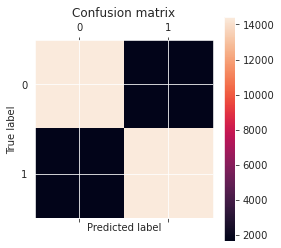

In [107]:
# visualize the classification result with confusion matrix
predictions = forest_clf.predict(test_d)
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)

plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     16035
           1       0.76      0.81      0.78     16082

    accuracy                           0.78     32117
   macro avg       0.78      0.78      0.78     32117
weighted avg       0.78      0.78      0.78     32117



In [46]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     16035
           1       0.88      0.87      0.87     16082

    accuracy                           0.87     32117
   macro avg       0.87      0.87      0.87     32117
weighted avg       0.87      0.87      0.87     32117



In [58]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     16035
           1       0.83      0.87      0.85     16082

    accuracy                           0.84     32117
   macro avg       0.85      0.84      0.84     32117
weighted avg       0.85      0.84      0.84     32117



In [72]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     16035
           1       0.76      0.82      0.79     16082

    accuracy                           0.78     32117
   macro avg       0.78      0.78      0.78     32117
weighted avg       0.78      0.78      0.78     32117



In [84]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     16035
           1       0.88      0.88      0.88     16082

    accuracy                           0.88     32117
   macro avg       0.88      0.88      0.88     32117
weighted avg       0.88      0.88      0.88     32117



In [96]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     16035
           1       0.89      0.88      0.89     16082

    accuracy                           0.89     32117
   macro avg       0.89      0.89      0.89     32117
weighted avg       0.89      0.89      0.89     32117



In [108]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     16035
           1       0.90      0.90      0.90     16082

    accuracy                           0.90     32117
   macro avg       0.90      0.90      0.90     32117
weighted avg       0.90      0.90      0.90     32117



In [109]:
# Use rfpimp library to analyse the importance of each feature
# the rfpimp.importances() function only accept train and test data in the form of dataframe

x = pd.DataFrame(test_d)
y = pd.DataFrame(test_lab)
x_columns = vec.get_feature_names()
x.columns = x_columns 

                           Importance
Feature                              
Adress_Count                 0.238378
LSOA_Count                   0.080051
Street                       0.049942
Residential Premises         0.049506
Commercial Premises          0.036025
Building Site                0.026030
Property Alarm               0.008998
Non Noise Complaint (45m)    0.000872
Email Complaint (1d)         0.000156


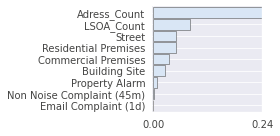

In [35]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.228072
LSOA_Count                   0.108665
Residential Premises         0.087742
Street                       0.077778
days                         0.072142
Commercial Premises          0.053990
Time                         0.048479
Weekday                      0.044027
Building Site                0.037145
Month                        0.021702
Season                       0.020114
Property Alarm               0.011676
Year                         0.011520
Non Noise Complaint (45m)    0.000778
Email Complaint (1d)         0.000062


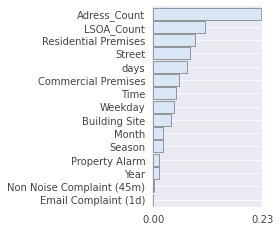

In [48]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.256780
bef_30_365days_count         0.073512
LSOA_Count                   0.068157
Residential Premises         0.064576
Street                       0.063238
bef_7_30days_count           0.057259
bef_2_7days_count            0.051966
bef_365_begindays_count      0.051499
Commercial Premises          0.045614
Building Site                0.029268
bef_todays_count             0.021141
bef_yesterday_count          0.019273
Property Alarm               0.009434
Non Noise Complaint (45m)    0.000716
Email Complaint (1d)         0.000093


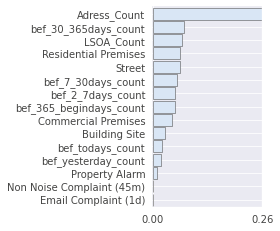

In [60]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.227450
Residential Premises         0.054800
Street                       0.050472
Commercial Premises          0.035869
LSOA_Count                   0.029548
Building Site                0.026310
time_cl_0                    0.008282
month_cl_0                   0.007628
Property Alarm               0.007317
time_cl_1                    0.006757
time_cl_2                    0.006009
year_month_cl_0              0.005760
year_month_cl_2              0.005418
year_month_cl_1              0.005324
weekday_cl_3                 0.005137
month_cl_1                   0.005044
month_cl_2                   0.004702
weekday_cl_0                 0.003518
weekday_cl_1                 0.003456
weekday_cl_2                 0.003332
Non Noise Complaint (45m)    0.000716
Email Complaint (1d)         0.000000


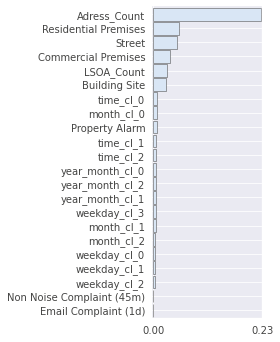

In [74]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.223464
Residential Premises         0.077342
Street                       0.069216
bef_30_365days_count         0.049538
Commercial Premises          0.047296
bef_7_30days_count           0.039667
bef_2_7days_count            0.032288
Time                         0.031665
LSOA_Count                   0.030420
bef_365_begindays_count      0.029517
Building Site                0.029175
days                         0.027400
Weekday                      0.023134
bef_todays_count             0.014821
Property Alarm               0.010711
Month                        0.008998
bef_yesterday_count          0.008438
Season                       0.006974
Year                         0.004359
Non Noise Complaint (45m)    0.000654
Email Complaint (1d)         0.000093


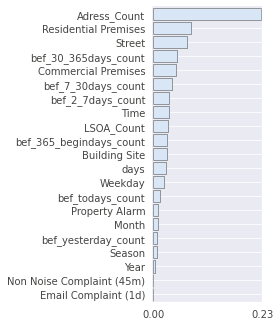

In [86]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.201482
days                         0.060933
Residential Premises         0.056792
Street                       0.056574
Commercial Premises          0.040633
time_cl_1                    0.039761
Time                         0.036429
Weekday                      0.028521
Building Site                0.027431
time_cl_2                    0.021858
time_cl_0                    0.020768
LSOA_Count                   0.018215
month_cl_2                   0.012486
year_month_cl_1              0.012361
year_month_cl_0              0.010462
month_cl_0                   0.010088
Month                        0.008656
month_cl_1                   0.008438
Property Alarm               0.007877
year_month_cl_2              0.005200
weekday_cl_3                 0.004670
Season                       0.004203
Year                         0.003518
weekday_cl_2                 0.002989
weekday_cl_0

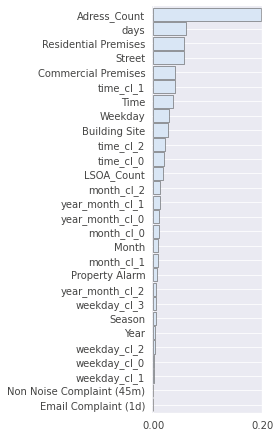

In [98]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.157144
Residential Premises         0.058536
Street                       0.051779
Commercial Premises          0.037208
Building Site                0.024099
bef_7_30days_count           0.022293
time_cl_1                    0.020052
bef_2_7days_count            0.018651
bef_30_365days_count         0.018433
Time                         0.015132
Weekday                      0.013202
time_cl_2                    0.012361
month_cl_2                   0.011365
time_cl_0                    0.011240
days                         0.009714
year_month_cl_1              0.009247
bef_todays_count             0.008500
year_month_cl_0              0.007659
month_cl_0                   0.007566
Property Alarm               0.007410
bef_365_begindays_count      0.007286
month_cl_1                   0.005916
weekday_cl_3                 0.005698
year_month_cl_2              0.005200
LSOA_Count  

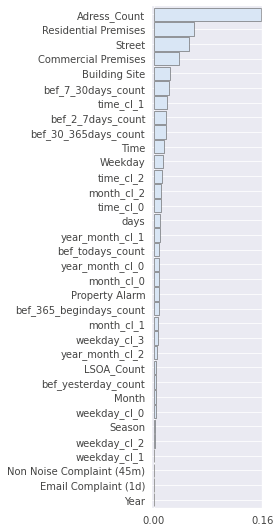

In [110]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

# Repeat complaint in 2-7 days

In [112]:
# CV method to Tune the model

In [113]:
#  Defome the shift_dataset
shift_dataset = s_2.copy()

In [114]:
shift_dataset.columns

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Noise_Complaint_Index', 'Time', 'Received_Date', 'Financial_Year',
       'Service_Request', 'Service_Request_Group_Type',
       'Service_Request_Group_Sub_Type', 'Service_Request_1', 'Address_Key_',
       'Type_of_Address', 'Output_Area_Code_(2011)', 'MSOA_2011_Code',
       'MSOA_2011_Name', 'LSOA_2011_Code', 'LSOA_2011_Name', 'Ward_Name',
       'Date', 'Days', 'Year_Month', 'Year_Week', 'Year', 'Month', 'Weekday',
       'Season', 'days', 'is_repeat_2days', 'is_repeat_7days',
       'is_repeat_30days', '2days_count', '7days_count', '30days_count',
       'bef_todays_count', 'bef_yesterday_count', 'bef_2_7days_count',
       'bef_7_30days_count', 'bef_30_365days_count', 'bef_365_begindays_count',
       'is_repeat_2_7days', 'is_repeat_7_30days', 'top5_lsoa_count',
       'LSOA_Count', 'top5_address_count', 'Adress_Count', 'LSOA11CD',
       'cluster0', 'cluster1', 'cluster2', 'is_high_hour', 'is_high_weekday',
      

In [115]:
shift_dataset

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [116]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 

    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [128]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [165]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                           
                                
       'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 

                                
       'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [177]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
    
        'LSOA_Count','Adress_Count',
    

    
       'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
    

    ]

    
    # Select columns from different dimensions
independent_columns = [
    
        'LSOA_Count','Adress_Count',
    
        
       'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
    

     ]

In [189]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [201]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [213]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3',
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [214]:

# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='not majority', random_state=42)

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(shift_dataset[independent_columns], shift_dataset['is_repeat_7days'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [215]:
oversampled

,is_repeat_7days,Year,Month,Weekday,Season,days,Time,bef_todays_count,bef_yesterday_count,bef_2_7days_count,...,weekday_cl_3,LSOA_Count,Adress_Count,Building Site,Commercial Premises,Email Complaint (1d),Non Noise Complaint (45m),Property Alarm,Residential Premises,Street
0,0,2018,4,6,2,0,0,0,0,0,...,0,1975,2,0,0,0,0,1,0,0
1,0,2018,4,6,2,0,0,0,0,0,...,1,843,1,0,0,0,0,0,1,0
2,0,2018,4,6,2,0,0,0,0,0,...,0,661,7,0,0,0,0,0,1,0
3,0,2018,4,6,2,0,0,0,0,0,...,0,527,5,0,0,0,0,0,1,0
4,0,2018,4,6,2,0,2,0,0,0,...,0,1566,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110441,1,2020,7,3,3,825,22,0,0,0,...,0,429,2,0,0,0,0,0,0,0
110442,1,2020,2,1,1,695,22,2,0,5,...,0,3763,1177,0,0,0,0,0,0,1
110443,1,2020,9,4,4,894,19,0,0,3,...,1,2139,140,0,0,0,0,0,0,1
110444,1,2019,9,3,4,536,13,0,0,0,...,0,2279,16,0,0,0,0,1,0,0


In [216]:
shift_dataset.loc[shift_dataset['is_repeat_7days'] ==1]

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
7,6541,7,7,NC8,6,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 005B,7068,1,1,1,7,11,0,0
9,7091,9,9,NC10,9,4/1/2018,2018/19,Building site,Noise Complaint,Building Site,...,0,Westminster 011E,7707,1,0,1,7,7,1,0
15,8081,15,15,NC16,14,4/1/2018,2018/19,Busker complaint,Noise Complaint,Street,...,1,Westminster 011B,8805,1,0,0,9,7,1,1
19,14883,19,19,NC20,17,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 010F,16398,0,0,0,1,6,1,1
22,16374,22,22,NC23,19,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013D,18053,0,1,0,2,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88276,33966,81489,81489,NC88277,4,3/31/2022,2021/22,Noise from commercial premises,Noise Complaint,Commercial Premises,...,0,Westminster 007G,37385,1,0,0,0,13,0,0
88288,69663,81499,81499,NC88289,13,3/31/2022,2021/22,Noise from commercial premises,Noise Complaint,Commercial Premises,...,1,Westminster 019D,75405,0,0,0,8,8,0,1
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0


In [217]:
#oversampled =oversampled.merge(shift_dataset[['Unnamed: 0_x','LSOA11CD']], left_on = 'Unnamed: 0_x', right_on = 'Unnamed: 0_x' )


In [218]:


le = LabelEncoder() # creates the LabelEncoder object
le.fit([ 0,1]) # encode '0','1','2' with 0, 1, 2 respectively
# runs LabelEncoder on the accident_count_levelcolumn
label_y = le.transform(oversampled['is_repeat_7days']) # runs LabelEncoder on the accident_count_levelcolumn

In [219]:
shift_dataset_2_dict = oversampled[independent_columns].to_dict('records')
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(shift_dataset_2_dict).toarray() 
print("Number of variables in this transformed data: {}".format(vec_array.shape[1]))
random_state_split = 1024


train_d, test_d, train_lab, test_lab = train_test_split(vec_array, label_y, random_state=random_state_split)
len(train_d),len(test_d),len(train_lab),len(test_lab)

Number of variables in this transformed data: 34


(82834, 27612, 82834, 27612)

In [ ]:
%%time
# Use gridsearchCV to explore the best combination of hyperparameter
# Considering the time consuming, range of grid_hyperparameters is very limited

# values of max_depth. 5 values ranging from 10 to 500
list_max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]

# values of n_estimators
list_n_estimators = [50, 100, 150, 200]
# create a grid of the two hyperparameters
#grid_hyperparameters = {'n_estimators':list_n_estimators,'max_depth': list_max_depth}
grid_hyperparameters = {'n_estimators':[50, 100, 150, 200,250,300,350,400,450,500],'max_depth': [10]}

random_state_rf = 200

rf = RandomForestClassifier(random_state_rf)

clf = model_selection.GridSearchCV(rf, grid_hyperparameters,cv=LSOA_cv )

#clf.fit(train_d, train_lab)
clf.fit(X, y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

In [123]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.8064683584035541
The accuracy of this classifier on the test data is:0.7756048095031146


In [135]:
random_state_RF = 200
forest_clf = RandomForestClassifier(random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9998672042880943
The accuracy of this classifier on the test data is:0.8367738664348834


In [172]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.955187483400536
The accuracy of this classifier on the test data is:0.8176879617557584


In [184]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.8079653282468552
The accuracy of this classifier on the test data is:0.7761118354338693


In [196]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.999975855325108
The accuracy of this classifier on the test data is:0.847457627118644


In [208]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9998792766255402
The accuracy of this classifier on the test data is:0.8503187020136173


In [220]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.999975855325108
The accuracy of this classifier on the test data is:0.8591192235260032


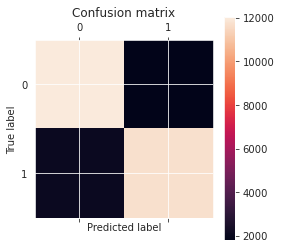

In [221]:
# visualize the classification result with confusion matrix
predictions = forest_clf.predict(test_d)
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)

plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [125]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     13807
           1       0.77      0.79      0.78     13805

    accuracy                           0.78     27612
   macro avg       0.78      0.78      0.78     27612
weighted avg       0.78      0.78      0.78     27612



In [137]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     13807
           1       0.84      0.83      0.83     13805

    accuracy                           0.84     27612
   macro avg       0.84      0.84      0.84     27612
weighted avg       0.84      0.84      0.84     27612



In [174]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81     13807
           1       0.80      0.84      0.82     13805

    accuracy                           0.82     27612
   macro avg       0.82      0.82      0.82     27612
weighted avg       0.82      0.82      0.82     27612



In [186]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     13807
           1       0.77      0.79      0.78     13805

    accuracy                           0.78     27612
   macro avg       0.78      0.78      0.78     27612
weighted avg       0.78      0.78      0.78     27612



In [198]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85     13807
           1       0.85      0.84      0.85     13805

    accuracy                           0.85     27612
   macro avg       0.85      0.85      0.85     27612
weighted avg       0.85      0.85      0.85     27612



In [210]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     13807
           1       0.86      0.84      0.85     13805

    accuracy                           0.85     27612
   macro avg       0.85      0.85      0.85     27612
weighted avg       0.85      0.85      0.85     27612



In [222]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     13807
           1       0.87      0.85      0.86     13805

    accuracy                           0.86     27612
   macro avg       0.86      0.86      0.86     27612
weighted avg       0.86      0.86      0.86     27612



In [223]:
# Use rfpimp library to analyse the importance of each feature
# the rfpimp.importances() function only accept train and test data in the form of dataframe

x = pd.DataFrame(test_d)
y = pd.DataFrame(test_lab)
x_columns = vec.get_feature_names()
x.columns = x_columns 

                           Importance
Feature                              
Adress_Count                 0.262965
LSOA_Count                   0.072468
Residential Premises         0.043278
Street                       0.036687
Commercial Premises          0.024048
Building Site                0.020390
Property Alarm               0.008764
Non Noise Complaint (45m)    0.000761
Email Complaint (1d)         0.000145


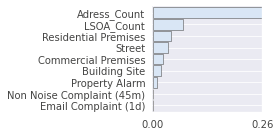

In [127]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.248877
Residential Premises         0.060662
LSOA_Count                   0.052984
Street                       0.050920
Commercial Premises          0.035854
Building Site                0.032196
Time                         0.029226
days                         0.026872
Weekday                      0.022454
Property Alarm               0.010177
Month                        0.009706
Season                       0.007207
Year                         0.002608
Non Noise Complaint (45m)    0.000652
Email Complaint (1d)         0.000036


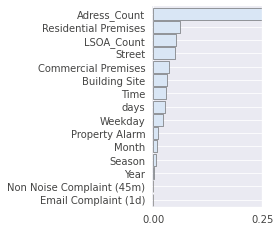

In [139]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.284369
bef_30_365days_count         0.049797
LSOA_Count                   0.041142
bef_365_begindays_count      0.039983
Residential Premises         0.038824
Street                       0.038787
bef_7_30days_count           0.028864
Commercial Premises          0.025641
bef_2_7days_count            0.025062
Building Site                0.017348
bef_todays_count             0.012784
bef_yesterday_count          0.010539
Property Alarm               0.006446
Non Noise Complaint (45m)    0.000326
Email Complaint (1d)         0.000072


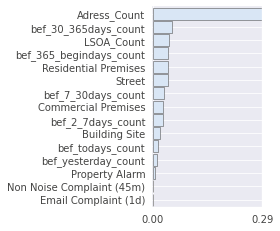

In [176]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.260285
Residential Premises         0.044546
Street                       0.034912
Commercial Premises          0.025895
LSOA_Count                   0.024482
Building Site                0.021838
Property Alarm               0.008764
time_cl_1                    0.004599
time_cl_0                    0.002825
year_month_cl_1              0.002535
weekday_cl_2                 0.002354
time_cl_2                    0.002173
month_cl_1                   0.001847
weekday_cl_1                 0.001775
year_month_cl_0              0.001775
year_month_cl_2              0.001775
month_cl_2                   0.000942
Non Noise Complaint (45m)    0.000579
weekday_cl_3                 0.000362
weekday_cl_0                 0.000109
Email Complaint (1d)         0.000000
month_cl_0                  -0.002137


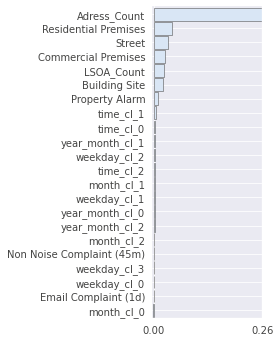

In [188]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.250072
Residential Premises         0.046429
Street                       0.044836
bef_30_365days_count         0.033174
Commercial Premises          0.029589
bef_365_begindays_count      0.028575
bef_2_7days_count            0.022599
bef_7_30days_count           0.022237
Building Site                0.019955
days                         0.016333
LSOA_Count                   0.015899
Time                         0.014233
Weekday                      0.011625
bef_todays_count             0.008511
Property Alarm               0.007026
bef_yesterday_count          0.004708
Month                        0.003839
Season                       0.002752
Year                         0.002282
Non Noise Complaint (45m)    0.000326
Email Complaint (1d)         0.000072


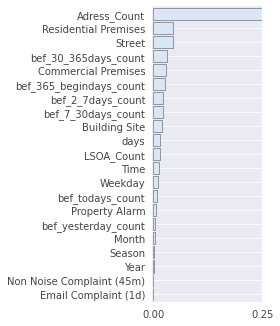

In [200]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.231023
Residential Premises         0.036325
Street                       0.034079
time_cl_1                    0.033283
Commercial Premises          0.025206
days                         0.024229
Building Site                0.021404
time_cl_2                    0.019448
Time                         0.018506
time_cl_0                    0.017927
Weekday                      0.017637
LSOA_Count                   0.012639
Month                        0.006736
month_cl_1                   0.006338
year_month_cl_1              0.005903
Property Alarm               0.005143
month_cl_2                   0.004672
month_cl_0                   0.004346
year_month_cl_0              0.003839
year_month_cl_2              0.002970
Season                       0.002354
weekday_cl_2                 0.001630
weekday_cl_3                 0.001086
weekday_cl_0                 0.000797
weekday_cl_1

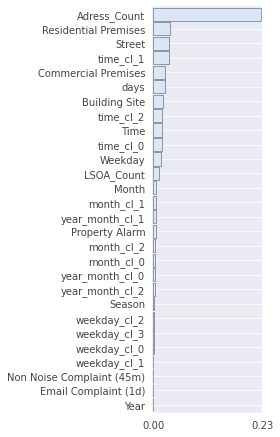

In [212]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.170397
Street                       0.034152
Residential Premises         0.032087
Commercial Premises          0.022019
bef_30_365days_count         0.020824
bef_2_7days_count            0.017348
bef_7_30days_count           0.016659
Building Site                0.015863
bef_365_begindays_count      0.014668
time_cl_1                    0.012350
Time                         0.010322
Weekday                      0.007968
time_cl_2                    0.007569
month_cl_2                   0.007497
bef_todays_count             0.007316
days                         0.007026
time_cl_0                    0.006410
month_cl_0                   0.005541
bef_yesterday_count          0.005179
year_month_cl_1              0.004889
Property Alarm               0.004672
year_month_cl_0              0.004491
LSOA_Count                   0.003839
Month                        0.003296
month_cl_1  

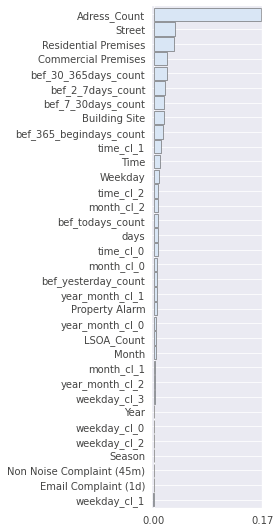

In [224]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

# Repeat complaint in next 30 days(today to tomorrow) 

In [225]:
# CV method to Tune the model

In [226]:
#  Defome the shift_dataset
shift_dataset = s_2.copy()

In [227]:
shift_dataset.columns

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Noise_Complaint_Index', 'Time', 'Received_Date', 'Financial_Year',
       'Service_Request', 'Service_Request_Group_Type',
       'Service_Request_Group_Sub_Type', 'Service_Request_1', 'Address_Key_',
       'Type_of_Address', 'Output_Area_Code_(2011)', 'MSOA_2011_Code',
       'MSOA_2011_Name', 'LSOA_2011_Code', 'LSOA_2011_Name', 'Ward_Name',
       'Date', 'Days', 'Year_Month', 'Year_Week', 'Year', 'Month', 'Weekday',
       'Season', 'days', 'is_repeat_2days', 'is_repeat_7days',
       'is_repeat_30days', '2days_count', '7days_count', '30days_count',
       'bef_todays_count', 'bef_yesterday_count', 'bef_2_7days_count',
       'bef_7_30days_count', 'bef_30_365days_count', 'bef_365_begindays_count',
       'is_repeat_2_7days', 'is_repeat_7_30days', 'top5_lsoa_count',
       'LSOA_Count', 'top5_address_count', 'Adress_Count', 'LSOA11CD',
       'cluster0', 'cluster1', 'cluster2', 'is_high_hour', 'is_high_weekday',
      

In [228]:
shift_dataset

,Unnamed: 0_x,Unnamed: 0.1,Unnamed: 0.1.1,Noise_Complaint_Index,Time,Received_Date,Financial_Year,Service_Request,Service_Request_Group_Type,Service_Request_Group_Sub_Type,...,weekday_cl_3,LSOA,Unnamed: 0_x,within_high_hours,within_high_weekdays,within_high_months,Days_oneyear_label,Hours_oneweek_label,Hours_oneweek_trend_label,Days_oneyear_trend_label
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,NC1,0,4/1/2018,2018/19,Burglar/fire alarm,Noise Complaint,Property Alarm,...,0,Westminster 018C,0,0,0,1,3,0,1,1
1,1975,1,1,NC2,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,1,Westminster 021C,2070,0,1,1,4,12,1,1
2,2818,2,2,NC3,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 023C,2978,0,0,1,4,4,1,0
3,3479,3,3,NC4,0,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 016C,3685,1,0,1,5,13,0,0
4,4006,4,4,NC5,2,4/1/2018,2018/19,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 013F,4283,0,1,1,6,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88294,9252,81502,81502,NC88295,18,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10103,0,0,0,9,6,1,0
88295,9253,81503,81503,NC88296,21,3/31/2022,2021/22,Noise in the street,Noise Complaint,Street,...,1,Westminster 011B,10104,0,0,0,9,6,1,0
88296,82443,81504,81504,NC88297,21,3/31/2022,2021/22,Residential noise,Noise Complaint,Residential Premises,...,0,Westminster 014F,89348,1,0,1,3,13,0,0


In [116]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 

    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [128]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [165]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                           
                                
       'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 

                                
       'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [264]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
    
        'LSOA_Count','Adress_Count',
    

    
       'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
    

    ]

    
    # Select columns from different dimensions
independent_columns = [
    
        'LSOA_Count','Adress_Count',
    
        
       'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
    

     ]

In [275]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [292]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [303]:
independent_and_LSOA_columns = [ 'Unnamed: 0.1',
                                
                                 'Year', 'Month', 'Weekday','Season', 'days','Time', 
                                'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
                                
                                'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3',
                                
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',
 ]

    
    # Select columns from different dimensions
independent_columns = [ 
     'Year', 'Month', 'Weekday','Season', 'days','Time', 
    'bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', 
    'year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 
    
       
       'month_cl_0', 'month_cl_1', 'month_cl_2',
    
       
       'time_cl_0', 'time_cl_1', 'time_cl_2', 
    
    
       'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 
      
    
    
        'LSOA_Count','Adress_Count',
      
                       
       'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street',]



In [304]:

# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='not majority', random_state=42)

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(shift_dataset[independent_columns], shift_dataset['is_repeat_7_30days'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [305]:
oversampled

,is_repeat_7_30days,Year,Month,Weekday,Season,days,Time,bef_todays_count,bef_yesterday_count,bef_2_7days_count,...,weekday_cl_3,LSOA_Count,Adress_Count,Building Site,Commercial Premises,Email Complaint (1d),Non Noise Complaint (45m),Property Alarm,Residential Premises,Street
0,0,2018,4,6,2,0,0,0,0,0,...,0,1975,2,0,0,0,0,1,0,0
1,0,2018,4,6,2,0,0,0,0,0,...,1,843,1,0,0,0,0,0,1,0
2,0,2018,4,6,2,0,0,0,0,0,...,0,661,7,0,0,0,0,0,1,0
3,1,2018,4,6,2,0,0,0,0,0,...,0,527,5,0,0,0,0,0,1,0
4,0,2018,4,6,2,0,2,0,0,0,...,0,1566,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141997,1,2021,2,4,1,1057,16,0,0,0,...,0,785,4,0,0,0,0,0,0,0
141998,1,2019,3,1,2,342,10,0,0,0,...,0,2279,24,0,0,0,0,0,0,0
141999,1,2018,4,1,2,3,22,0,0,0,...,1,618,12,0,1,0,0,0,0,0
142000,1,2020,4,1,2,745,10,0,0,0,...,1,834,5,0,0,0,0,0,1,0


In [306]:
#oversampled =oversampled.merge(shift_dataset[['Unnamed: 0_x','LSOA11CD']], left_on = 'Unnamed: 0_x', right_on = 'Unnamed: 0_x' )


In [307]:


le = LabelEncoder() # creates the LabelEncoder object
le.fit([ 0,1]) # encode '0','1','2' with 0, 1, 2 respectively
# runs LabelEncoder on the accident_count_levelcolumn
label_y = le.transform(oversampled['is_repeat_7_30days']) # runs LabelEncoder on the accident_count_levelcolumn

In [308]:
shift_dataset_2_dict = oversampled[independent_columns].to_dict('records')
vec = DictVectorizer()  # create the DictVectorizer object
vec_array = vec.fit_transform(shift_dataset_2_dict).toarray() 
print("Number of variables in this transformed data: {}".format(vec_array.shape[1]))
random_state_split = 1024


train_d, test_d, train_lab, test_lab = train_test_split(vec_array, label_y, random_state=random_state_split)
len(train_d),len(test_d),len(train_lab),len(test_lab)

Number of variables in this transformed data: 34


(106501, 35501, 106501, 35501)

In [ ]:
%%time
# Use gridsearchCV to explore the best combination of hyperparameter
# Considering the time consuming, range of grid_hyperparameters is very limited

# values of max_depth. 5 values ranging from 10 to 500
list_max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]

# values of n_estimators
list_n_estimators = [50, 100, 150, 200]
# create a grid of the two hyperparameters
#grid_hyperparameters = {'n_estimators':list_n_estimators,'max_depth': list_max_depth}
grid_hyperparameters = {'n_estimators':[50, 100, 150, 200,250,300,350,400,450,500],'max_depth': [10]}

random_state_rf = 200

rf = RandomForestClassifier(random_state_rf)

clf = model_selection.GridSearchCV(rf, grid_hyperparameters,cv=LSOA_cv )

#clf.fit(train_d, train_lab)
clf.fit(X, y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

In [235]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.7852884010478774
The accuracy of this classifier on the test data is:0.7639503112588378


In [246]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9997464812536971
The accuracy of this classifier on the test data is:0.8888763696797274


In [257]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9545262485798255
The accuracy of this classifier on the test data is:0.84966620658573


In [270]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.7890254551600454
The accuracy of this classifier on the test data is:0.7670769837469367


In [281]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.999953052084018
The accuracy of this classifier on the test data is:0.8882003323850033


In [298]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.99976526042009
The accuracy of this classifier on the test data is:0.9074673952846398


In [309]:
random_state_RF = 200
forest_clf = RandomForestClassifier( random_state = random_state_RF)
forest_clf.fit(train_d,train_lab)
print("The accuracy of this classifier on the train data is:{}".format(forest_clf.score(train_d, train_lab)))
print("The accuracy of this classifier on the test data is:{}".format(forest_clf.score(test_d, test_lab)))

The accuracy of this classifier on the train data is:0.9999624416672144
The accuracy of this classifier on the test data is:0.9115799554942114


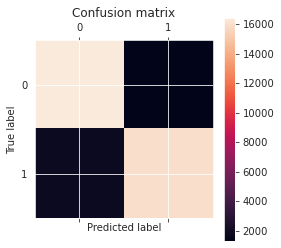

In [310]:
# visualize the classification result with confusion matrix
predictions = forest_clf.predict(test_d)
confusion_matrix = metrics.confusion_matrix(test_lab, predictions)

plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [237]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75     17756
           1       0.74      0.82      0.78     17745

    accuracy                           0.76     35501
   macro avg       0.77      0.76      0.76     35501
weighted avg       0.77      0.76      0.76     35501



In [248]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     17756
           1       0.89      0.88      0.89     17745

    accuracy                           0.89     35501
   macro avg       0.89      0.89      0.89     35501
weighted avg       0.89      0.89      0.89     35501



In [259]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85     17756
           1       0.83      0.88      0.85     17745

    accuracy                           0.85     35501
   macro avg       0.85      0.85      0.85     35501
weighted avg       0.85      0.85      0.85     35501



In [272]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76     17756
           1       0.74      0.82      0.78     17745

    accuracy                           0.77     35501
   macro avg       0.77      0.77      0.77     35501
weighted avg       0.77      0.77      0.77     35501



In [283]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     17756
           1       0.89      0.89      0.89     17745

    accuracy                           0.89     35501
   macro avg       0.89      0.89      0.89     35501
weighted avg       0.89      0.89      0.89     35501



In [300]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17756
           1       0.92      0.89      0.91     17745

    accuracy                           0.91     35501
   macro avg       0.91      0.91      0.91     35501
weighted avg       0.91      0.91      0.91     35501



In [311]:
print (metrics.classification_report(test_lab, predictions))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     17756
           1       0.92      0.90      0.91     17745

    accuracy                           0.91     35501
   macro avg       0.91      0.91      0.91     35501
weighted avg       0.91      0.91      0.91     35501



In [312]:
# Use rfpimp library to analyse the importance of each feature
# the rfpimp.importances() function only accept train and test data in the form of dataframe

x = pd.DataFrame(test_d)
y = pd.DataFrame(test_lab)
x_columns = vec.get_feature_names()
x.columns = x_columns 

                           Importance
Feature                              
Adress_Count                 0.200755
LSOA_Count                   0.116926
Residential Premises         0.075857
Street                       0.038140
Commercial Premises          0.035661
Building Site                0.025492
Property Alarm               0.019943
Non Noise Complaint (45m)    0.000648
Email Complaint (1d)         0.000197


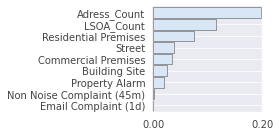

In [239]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.148334
Residential Premises         0.120447
LSOA_Count                   0.080730
Street                       0.079040
days                         0.071294
Time                         0.055576
Weekday                      0.055491
Commercial Premises          0.055266
Month                        0.044337
Year                         0.038619
Season                       0.038112
Building Site                0.036196
Property Alarm               0.021239
Non Noise Complaint (45m)    0.000648
Email Complaint (1d)         0.000056


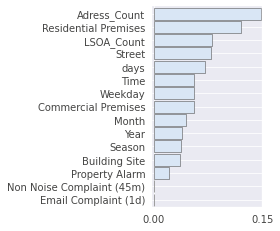

In [250]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.233430
bef_30_365days_count         0.111490
LSOA_Count                   0.093857
Residential Premises         0.085068
bef_365_begindays_count      0.066928
bef_7_30days_count           0.054477
Street                       0.050506
bef_2_7days_count            0.036731
Commercial Premises          0.034478
Building Site                0.029689
bef_yesterday_count          0.023042
bef_todays_count             0.020112
Property Alarm               0.018901
Non Noise Complaint (45m)    0.000451
Email Complaint (1d)         0.000028


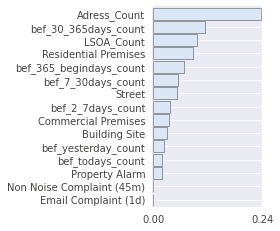

In [261]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.197938
Residential Premises         0.072928
LSOA_Count                   0.057041
Commercial Premises          0.042280
Street                       0.041773
Building Site                0.027492
Property Alarm               0.019211
weekday_cl_2                 0.013577
time_cl_0                    0.011915
year_month_cl_2              0.011436
weekday_cl_3                 0.011380
time_cl_2                    0.010000
month_cl_2                   0.009831
year_month_cl_1              0.007436
month_cl_1                   0.007098
time_cl_1                    0.006704
month_cl_0                   0.006479
year_month_cl_0              0.006197
weekday_cl_0                 0.005972
weekday_cl_1                 0.005296
Non Noise Complaint (45m)    0.000394
Email Complaint (1d)         0.000028


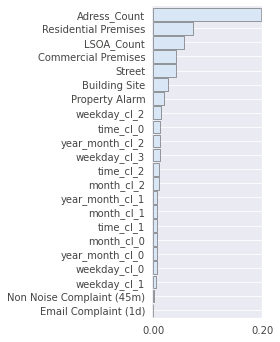

In [274]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.161066
Residential Premises         0.094476
bef_30_365days_count         0.061998
Street                       0.058055
Commercial Premises          0.038506
LSOA_Count                   0.036281
Weekday                      0.034816
Time                         0.032760
bef_365_begindays_count      0.031520
Building Site                0.029943
days                         0.027718
bef_7_30days_count           0.027041
bef_2_7days_count            0.020563
Property Alarm               0.017859
Month                        0.017098
bef_yesterday_count          0.016732
bef_todays_count             0.014732
Season                       0.007521
Year                         0.004958
Non Noise Complaint (45m)    0.000394
Email Complaint (1d)         0.000028


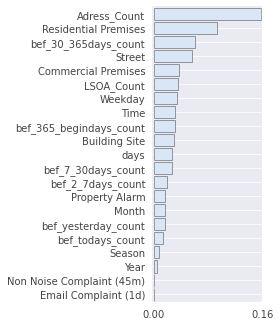

In [285]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Residential Premises         0.118560
Adress_Count                 0.111377
Street                       0.063688
Commercial Premises          0.046280
days                         0.037098
Time                         0.031774
Weekday                      0.029886
Building Site                0.028732
LSOA_Count                   0.024027
Month                        0.018732
weekday_cl_3                 0.018619
Property Alarm               0.018535
month_cl_2                   0.017830
month_cl_0                   0.016647
time_cl_1                    0.015549
month_cl_1                   0.014901
Season                       0.011718
time_cl_0                    0.011464
time_cl_2                    0.011042
Year                         0.010591
weekday_cl_0                 0.010507
year_month_cl_0              0.010338
year_month_cl_1              0.010281
year_month_cl_2              0.009267
weekday_cl_1

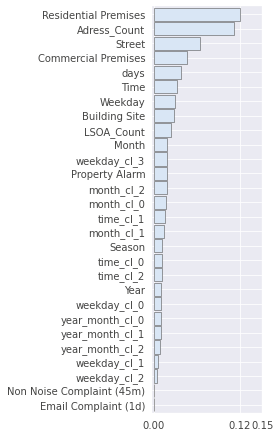

In [302]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

                           Importance
Feature                              
Adress_Count                 0.109941
Residential Premises         0.089209
Street                       0.045154
bef_30_365days_count         0.033154
Commercial Premises          0.031774
Building Site                0.027041
Weekday                      0.020816
Property Alarm               0.016985
Time                         0.016028
bef_7_30days_count           0.014732
days                         0.012422
time_cl_1                    0.011690
LSOA_Count                   0.011464
bef_2_7days_count            0.011380
month_cl_2                   0.010535
bef_yesterday_count          0.010028
month_cl_0                   0.009324
month_cl_1                   0.009296
bef_365_begindays_count      0.008901
Month                        0.008704
year_month_cl_0              0.008676
bef_todays_count             0.008535
weekday_cl_3                 0.008310
year_month_cl_1              0.008056
time_cl_0   

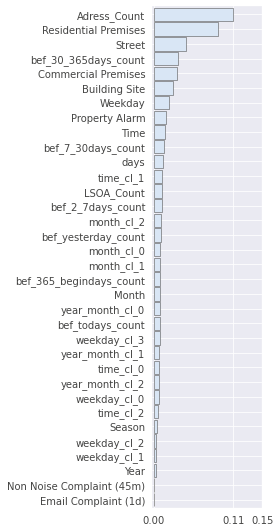

In [313]:
# import model, the test data and lable in the importance funciton
imp = rfpimp.importances(forest_clf, x, y, n_samples=-1) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

# Visualisation of the result

In [19]:
RF_result_collection = pd.read_csv('RF_model_accuracy_update_2.csv').dropna()

In [20]:
RF_result_collection

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
0,2days,normal,A,0,0.799988,0.777252,0.80,0.74,0.77,16035
1,2days,normal,A,1,0.799988,0.777252,0.76,0.81,0.78,16082
2,2days,normal,A+B,0,0.999606,0.871563,0.87,0.88,0.87,16035
3,2days,normal,A+B,1,0.999606,0.871563,0.88,0.87,0.87,16082
4,2days,normal,A+C,0,0.956824,0.844880,0.87,0.82,0.84,16035
5,2days,normal,A+C,1,0.956824,0.844880,0.83,0.87,0.85,16082
6,2days,normal,A+D,0,0.802863,0.779494,0.80,0.74,0.77,16035
7,2days,normal,A+D,1,0.802863,0.779494,0.76,0.82,0.79,16082
8,2days,normal,A+B+C,0,0.999958,0.881651,0.88,0.88,0.88,16035
9,2days,normal,A+B+C,1,0.999958,0.881651,0.88,0.88,0.88,16082


In [21]:
RF_result_collection_2days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2days') & (RF_result_collection.combination.isin (['A+B','A+C','A+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_2days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
2,2days,normal,A+B,0,0.999606,0.871563,0.87,0.88,0.87,16035
4,2days,normal,A+C,0,0.956824,0.844880,0.87,0.82,0.84,16035
6,2days,normal,A+D,0,0.802863,0.779494,0.80,0.74,0.77,16035


In [22]:
RF_result_collection_2_7days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2-7days') & (RF_result_collection.combination.isin (['A+B','A+C','A+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_2_7days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
16,2-7days,normal,A+B,0,0.999867,0.836774,0.83,0.85,0.84,13807
18,2-7days,normal,A+C,0,0.955187,0.817688,0.83,0.79,0.81,13807
20,2-7days,normal,A+D,0,0.807965,0.776112,0.78,0.76,0.77,13807


In [23]:
RF_result_collection_7_30days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '7-30days') & (RF_result_collection.combination.isin (['A+B','A+C','A+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_7_30days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
30,7-30days,normal,A+B,0,0.999746,0.888876,0.88,0.90,0.89,17756
32,7-30days,normal,A+C,0,0.954526,0.849666,0.87,0.82,0.85,17756
34,7-30days,normal,A+D,0,0.789025,0.767077,0.80,0.72,0.76,17756


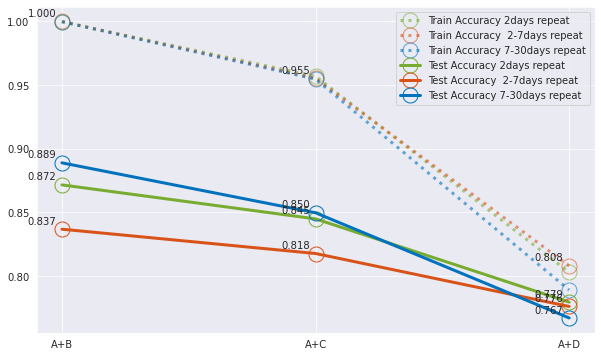

In [24]:
data_1 = RF_result_collection_2days_normal
data_2 = RF_result_collection_2_7days_normal
data_3 = RF_result_collection_7_30days_normal


x_ticks = range(0,3,1)
x_labels = ['A+B','A+C','A+D']
fig, ax = plt.subplots(1,1,figsize=(10,6))

#ax.plot(
    #data_1.combination, data_1.Test_Accuracy, ls="--", lw=3, 
    #marker="X", markersize=10, markerfacecolor="red", markeredgecolor="black",
    #label="2days_repeat"
#)



# Train Accuracy

ax.plot(
    data_1.combination, data_1.Train_Accuracy, ls=":", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30', alpha = 0.6,
    label="Train Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', alpha = 0.6,
    label="Train Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD', alpha = 0.6,
    label="Train Accuracy 7-30days repeat"
)

# test accuracy
ax.plot(
    data_1.combination, data_1.Test_Accuracy, ls="-", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30',
    label="Test Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', 
    label="Test Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD',
    label="Test Accuracy 7-30days repeat"
)




for x,y in zip(data_1.combination,data_1.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(data_2.combination,data_2.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   
    
for x,y in zip(data_3.combination,data_3.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   

    
    
for x,y in zip(data_2.combination,data_2.Train_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   


ax.set_xticks(x_ticks)

ax.set_xticklabels(x_labels, rotation='horizontal', fontsize=10)

#plt.grid(False)
plt.legend()
plt.show()

In [25]:
RF_result_collection_2days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2days') & (RF_result_collection.combination.isin (['A','A+B','A+B+C','A+B+C+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_2days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
0,2days,normal,A,0,0.799988,0.777252,0.80,0.74,0.77,16035
2,2days,normal,A+B,0,0.999606,0.871563,0.87,0.88,0.87,16035
8,2days,normal,A+B+C,0,0.999958,0.881651,0.88,0.88,0.88,16035
12,2days,normal,A+B+C+D,0,0.999948,0.895818,0.90,0.90,0.90,16035


In [26]:
RF_result_collection_2_7days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2-7days') & (RF_result_collection.combination.isin (['A','A+B','A+B+C','A+B+C+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_2_7days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
14,2-7days,normal,A,0,0.806468,0.775605,0.78,0.76,0.77,13807
16,2-7days,normal,A+B,0,0.999867,0.836774,0.83,0.85,0.84,13807
22,2-7days,normal,A+B+C,0,0.999976,0.847458,0.84,0.85,0.85,13807
26,2-7days,normal,A+B+C+D,0,0.999976,0.859119,0.85,0.87,0.86,13807


In [27]:
RF_result_collection_7_30days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '7-30days') & (RF_result_collection.combination.isin (['A','A+B','A+B+C','A+B+C+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_7_30days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
28,7-30days,normal,A,0,0.785288,0.763950,0.79,0.71,0.75,17756
30,7-30days,normal,A+B,0,0.999746,0.888876,0.88,0.90,0.89,17756
36,7-30days,normal,A+B+C,0,0.999953,0.888200,0.89,0.89,0.89,17756
40,7-30days,normal,A+B+C+D,0,0.999962,0.911580,0.90,0.93,0.91,17756


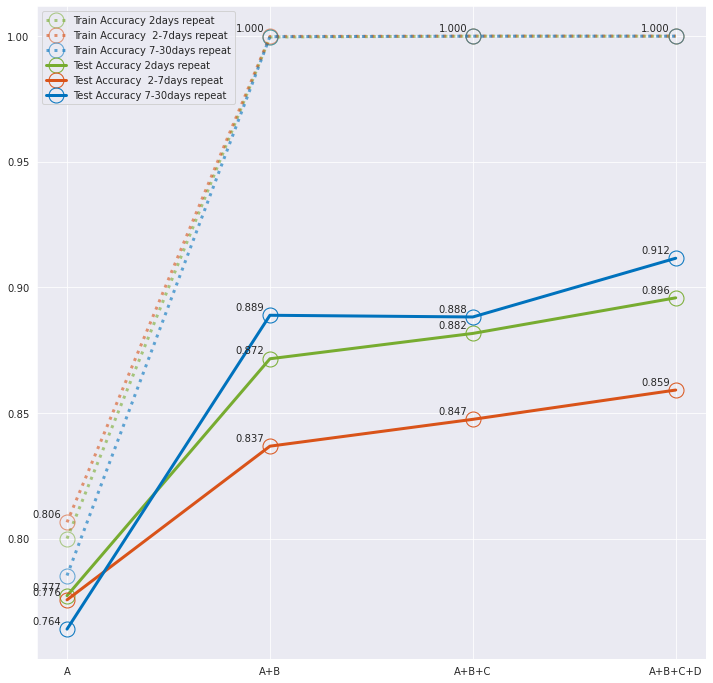

In [28]:
data_1 = RF_result_collection_2days_normal
data_2 = RF_result_collection_2_7days_normal
data_3 = RF_result_collection_7_30days_normal


x_ticks = range(0,4,1)
x_labels = ['A','A+B','A+B+C','A+B+C+D']
fig, ax = plt.subplots(1,1,figsize=(12,12))

#ax.plot(
    #data_1.combination, data_1.Test_Accuracy, ls="--", lw=3, 
    #marker="X", markersize=10, markerfacecolor="red", markeredgecolor="black",
    #label="2days_repeat"
#)



# Train Accuracy

ax.plot(
    data_1.combination, data_1.Train_Accuracy, ls=":", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30', alpha = 0.6,
    label="Train Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', alpha = 0.6,
    label="Train Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD', alpha = 0.6,
    label="Train Accuracy 7-30days repeat"
)

# test accuracy
ax.plot(
    data_1.combination, data_1.Test_Accuracy, ls="-", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30',
    label="Test Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', 
    label="Test Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD',
    label="Test Accuracy 7-30days repeat"
)




for x,y in zip(data_1.combination,data_1.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(data_2.combination,data_2.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   
    
for x,y in zip(data_3.combination,data_3.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   

    
    
for x,y in zip(data_2.combination,data_2.Train_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   


ax.set_xticks(x_ticks)

ax.set_xticklabels(x_labels, rotation='horizontal', fontsize=10)

#plt.grid(False)
plt.legend()
plt.show()

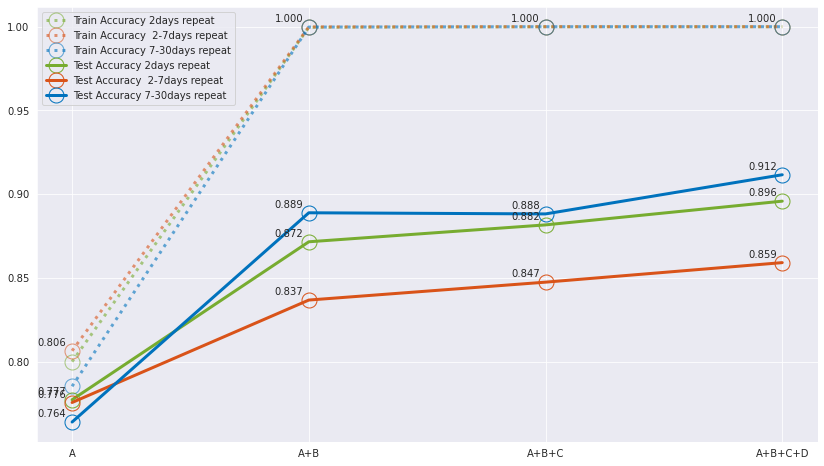

In [36]:
data_1 = RF_result_collection_2days_normal
data_2 = RF_result_collection_2_7days_normal
data_3 = RF_result_collection_7_30days_normal


x_ticks = range(0,4,1)
x_labels = ['A','A+B','A+B+C','A+B+C+D']
fig, ax = plt.subplots(1,1,figsize=(14,8))

#ax.plot(
    #data_1.combination, data_1.Test_Accuracy, ls="--", lw=3, 
    #marker="X", markersize=10, markerfacecolor="red", markeredgecolor="black",
    #label="2days_repeat"
#)



# Train Accuracy

ax.plot(
    data_1.combination, data_1.Train_Accuracy, ls=":", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30', alpha = 0.6,
    label="Train Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', alpha = 0.6,
    label="Train Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD', alpha = 0.6,
    label="Train Accuracy 7-30days repeat"
)

# test accuracy
ax.plot(
    data_1.combination, data_1.Test_Accuracy, ls="-", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30',
    label="Test Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', 
    label="Test Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD',
    label="Test Accuracy 7-30days repeat"
)




for x,y in zip(data_1.combination,data_1.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(data_2.combination,data_2.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   
    
for x,y in zip(data_3.combination,data_3.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   

    
    
for x,y in zip(data_2.combination,data_2.Train_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   


ax.set_xticks(x_ticks)

ax.set_xticklabels(x_labels, rotation='horizontal', fontsize=10)

#plt.grid(False)
plt.legend()
plt.show()

In [23]:
RF_result_collection_2days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2days') & (RF_result_collection.combination.isin (['A+B+C','A+B+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_2days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
8,2days,normal,A+B+C,0,0.999958,0.881651,0.88,0.88,0.88,16035
10,2days,normal,A+B+D,0,0.999637,0.886509,0.88,0.89,0.89,16035


In [24]:
RF_result_collection_2_7days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2-7days') & (RF_result_collection.combination.isin (['A+B+C','A+B+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_2_7days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
22,2-7days,normal,A+B+C,0,0.999976,0.847458,0.84,0.85,0.85,13807
24,2-7days,normal,A+B+D,0,0.999879,0.850319,0.84,0.86,0.85,13807


In [25]:
RF_result_collection_7_30days_normal = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '7-30days') & (RF_result_collection.combination.isin (['A+B+C','A+B+D'])) ].drop_duplicates(subset = ['combination'])
RF_result_collection_7_30days_normal

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
36,7-30days,normal,A+B+C,0,0.999953,0.888200,0.89,0.89,0.89,17756
38,7-30days,normal,A+B+D,0,0.999765,0.907467,0.90,0.92,0.91,17756


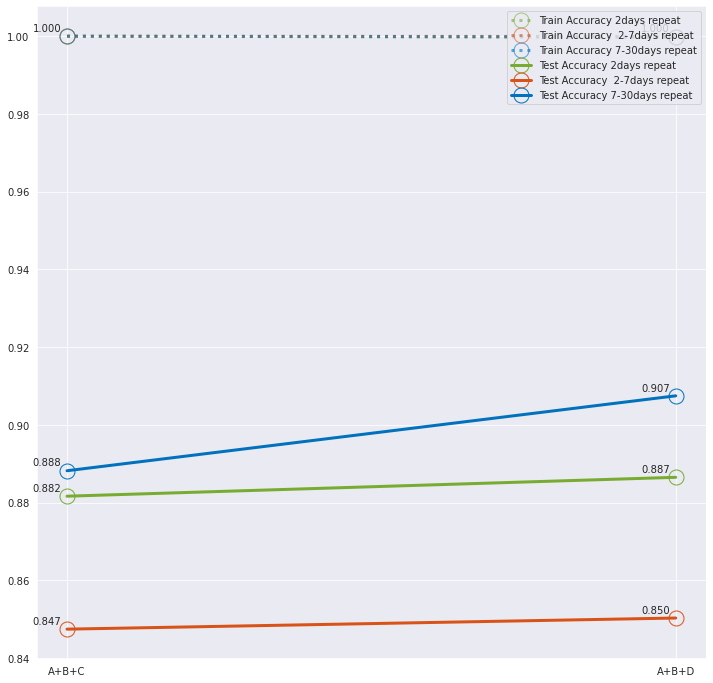

In [26]:
data_1 = RF_result_collection_2days_normal
data_2 = RF_result_collection_2_7days_normal
data_3 = RF_result_collection_7_30days_normal


x_ticks = range(0,2,1)
x_labels = ['A+B+C','A+B+D']
fig, ax = plt.subplots(1,1,figsize=(12,12))

#ax.plot(
    #data_1.combination, data_1.Test_Accuracy, ls="--", lw=3, 
    #marker="X", markersize=10, markerfacecolor="red", markeredgecolor="black",
    #label="2days_repeat"
#)



# Train Accuracy

ax.plot(
    data_1.combination, data_1.Train_Accuracy, ls=":", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30', alpha = 0.6,
    label="Train Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', alpha = 0.6,
    label="Train Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Train_Accuracy, ls=":", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD', alpha = 0.6,
    label="Train Accuracy 7-30days repeat"
)

# test accuracy
ax.plot(
    data_1.combination, data_1.Test_Accuracy, ls="-", lw=3, 
    marker="o", markersize=15, markerfacecolor="none", color = '#77AC30',
    label="Test Accuracy 2days repeat"
)

ax.plot(
    data_2.combination, data_2.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color ='#D95319', 
    label="Test Accuracy  2-7days repeat"
)
ax.plot(
    data_3.combination, data_3.Test_Accuracy, ls="-", lw=3,
    marker="o", markersize=15, markerfacecolor="None", color = '#0072BD',
    label="Test Accuracy 7-30days repeat"
)




for x,y in zip(data_1.combination,data_1.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(data_2.combination,data_2.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   
    
for x,y in zip(data_3.combination,data_3.Test_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   

    
    
for x,y in zip(data_2.combination,data_2.Train_Accuracy):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center   


ax.set_xticks(x_ticks)

ax.set_xticklabels(x_labels, rotation='horizontal', fontsize=10)

#plt.grid(False)
plt.legend(loc = 'upper right')
plt.show()

In [27]:
# 接下来想画一个分别显示 非重复-重复 非重复-重复 非重复-重复的招呼率的图

In [28]:
RF_result_collection_2days_normal_1 = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2days') & (RF_result_collection.combination.isin (['A','A+B','A+C+D','A+B+C+D'])) ]
RF_result_collection_2days_normal_1

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
0,2days,normal,A,0,0.799988,0.777252,0.80,0.74,0.77,16035
1,2days,normal,A,1,0.799988,0.777252,0.76,0.81,0.78,16082
2,2days,normal,A+B,0,0.999606,0.871563,0.87,0.88,0.87,16035
3,2days,normal,A+B,1,0.999606,0.871563,0.88,0.87,0.87,16082
12,2days,normal,A+B+C+D,0,0.999948,0.895818,0.90,0.90,0.90,16035
13,2days,normal,A+B+C+D,1,0.999948,0.895818,0.90,0.90,0.90,16082


In [29]:
RF_result_collection_2days_normal_2 = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '2-7days') & (RF_result_collection.combination.isin (['A','A+B','A+C+D','A+B+C+D']))  ]
RF_result_collection_2days_normal_2

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
14,2-7days,normal,A,0,0.806468,0.775605,0.78,0.76,0.77,13807
15,2-7days,normal,A,1,0.806468,0.775605,0.77,0.79,0.78,13805
16,2-7days,normal,A+B,0,0.999867,0.836774,0.83,0.85,0.84,13807
17,2-7days,normal,A+B,1,0.999867,0.836774,0.84,0.83,0.83,13805
26,2-7days,normal,A+B+C+D,0,0.999976,0.859119,0.85,0.87,0.86,13807
27,2-7days,normal,A+B+C+D,1,0.999976,0.859119,0.87,0.85,0.86,13805


In [30]:
RF_result_collection_2days_normal_3 = RF_result_collection.loc[(RF_result_collection.Predict_cycle == '7-30days') & (RF_result_collection.combination.isin (['A','A+B','A+C+D','A+B+C+D'])) ]
RF_result_collection_2days_normal_3

,Predict_cycle,CV_Type,combination,Predicted Variable,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
28,7-30days,normal,A,0,0.785288,0.763950,0.79,0.71,0.75,17756
29,7-30days,normal,A,1,0.785288,0.763950,0.74,0.82,0.78,17745
30,7-30days,normal,A+B,0,0.999746,0.888876,0.88,0.90,0.89,17756
31,7-30days,normal,A+B,1,0.999746,0.888876,0.89,0.88,0.89,17745
40,7-30days,normal,A+B+C+D,0,0.999962,0.911580,0.90,0.93,0.91,17756
41,7-30days,normal,A+B+C+D,1,0.999962,0.911580,0.92,0.90,0.91,17745


In [31]:
RF_result_collection_normal = RF_result_collection.loc[ (RF_result_collection.combination.isin (['A','A+B','A+C+D','A+B+C+D'])) ]
RF_result_collection_normal

RF_result_collection_normal.rename(columns ={'Predicted Variable':'Recall_Score_Type'},inplace = True)
RF_result_collection_normal.loc[RF_result_collection_normal['Recall_Score_Type'] == 0, 'Recall_Score_Type'] ='Not Repeat' 
RF_result_collection_normal.loc[RF_result_collection_normal['Recall_Score_Type'] == 1, 'Recall_Score_Type'] ='Repeat' 

In [32]:
RF_result_collection_normal

,Predict_cycle,CV_Type,combination,Recall_Score_Type,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score,Support
0,2days,normal,A,Not Repeat,0.799988,0.777252,0.80,0.74,0.77,16035
1,2days,normal,A,Repeat,0.799988,0.777252,0.76,0.81,0.78,16082
2,2days,normal,A+B,Not Repeat,0.999606,0.871563,0.87,0.88,0.87,16035
3,2days,normal,A+B,Repeat,0.999606,0.871563,0.88,0.87,0.87,16082
12,2days,normal,A+B+C+D,Not Repeat,0.999948,0.895818,0.90,0.90,0.90,16035
13,2days,normal,A+B+C+D,Repeat,0.999948,0.895818,0.90,0.90,0.90,16082
14,2-7days,normal,A,Not Repeat,0.806468,0.775605,0.78,0.76,0.77,13807
15,2-7days,normal,A,Repeat,0.806468,0.775605,0.77,0.79,0.78,13805
16,2-7days,normal,A+B,Not Repeat,0.999867,0.836774,0.83,0.85,0.84,13807
17,2-7days,normal,A+B,Repeat,0.999867,0.836774,0.84,0.83,0.83,13805


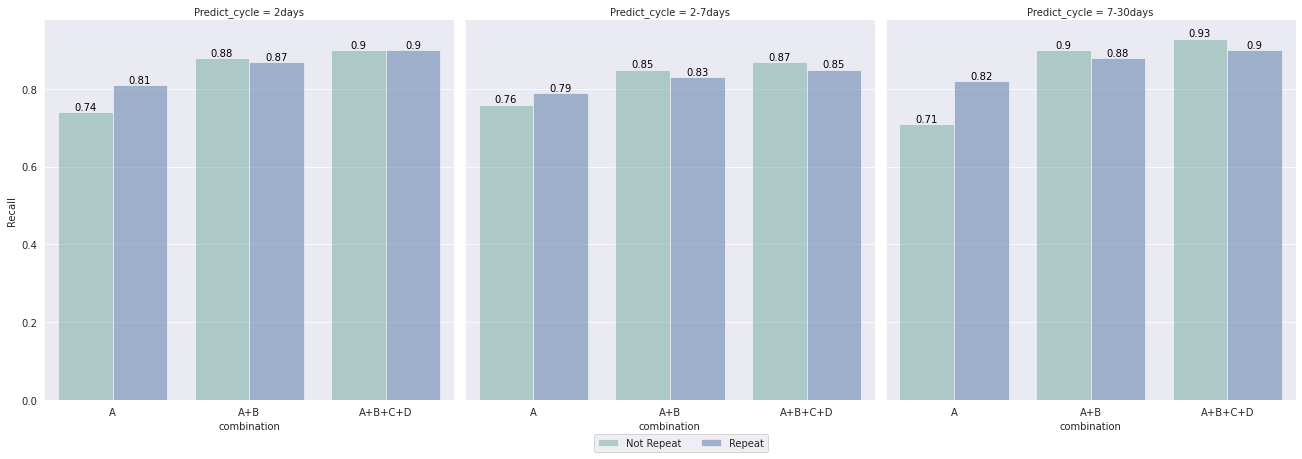

In [49]:
colors = ["#69b3a2", "#4374B3"]
pal = sns.color_palette(colors)
g = sns.catplot(x="combination", y="Recall",hue="Recall_Score_Type", col="Predict_cycle",data=RF_result_collection_normal, kind="bar",height=6, aspect=1, alpha=0.5,palette=pal, legend = False);


ax = plt.gca()

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), p.get_height(), 
            fontsize=10, color='black', ha='center', va='bottom')

plt.legend(loc = 'lower center', bbox_to_anchor=(-0.5, -0.15),
          ncol=3, )

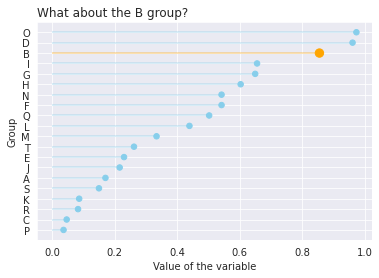

In [352]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
# Create a dataframe
df = pd.DataFrame({'group':list(map(chr, range(65, 85))), 'values':np.random.uniform(size=20) })
 
# Reorder it based on values:
ordered_df = df.sort_values(by='values')
my_range=range(1,len(df.index)+1)
 
# Create a color if the group is "B"
my_color=np.where(ordered_df ['group']=='B', 'orange', 'skyblue')
my_size=np.where(ordered_df ['group']=='B', 70, 30)
 
# The horizontal plot is made using the hline() function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['values'], color=my_color, alpha=0.4)
plt.scatter(ordered_df['values'], my_range, color=my_color, s=my_size, alpha=1)
 
# Add title and axis names
plt.yticks(my_range, ordered_df['group'])
plt.title("What about the B group?", loc='left')
plt.xlabel('Value of the variable')
plt.ylabel('Group')

# show the graph
plt.show()

In [354]:
importance_collection = pd.read_csv('RF_model_importance.csv')

In [355]:
importance_collection

,Feature,Importance,Type
0,Adress_Count,0.109941,7-30 days
1,Residential Premises,0.089209,7-30 days
2,Street,0.045154,7-30 days
3,bef_30_365days_count,0.033154,7-30 days
4,Commercial Premises,0.031774,7-30 days
...,...,...,...
97,weekday_cl_2,0.001681,0-2 days
98,weekday_cl_1,0.000872,0-2 days
99,Non Noise Complaint (45m),0.000187,0-2 days
100,Email Complaint (1d),0.000000,0-2 days


In [356]:
A = ['LSOA_Count','Adress_Count',
      'Building Site', 'Commercial Premises', 'Email Complaint (1d)','Non Noise Complaint (45m)', 'Property Alarm', 'Residential Premises','Street']

B = ['Year', 'Month', 'Weekday','Season', 'days','Time',]
   
C = ['bef_todays_count','bef_yesterday_count', 'bef_2_7days_count', 'bef_7_30days_count','bef_30_365days_count', 'bef_365_begindays_count', ]

D = ['year_month_cl_0', 'year_month_cl_1','year_month_cl_2', 'month_cl_0', 'month_cl_1', 'month_cl_2',
      
       'time_cl_0', 'time_cl_1', 'time_cl_2', 'weekday_cl_0', 'weekday_cl_1','weekday_cl_2', 'weekday_cl_3', 'weekday_cl_4', 'weekday_cl_5']
      
    
    

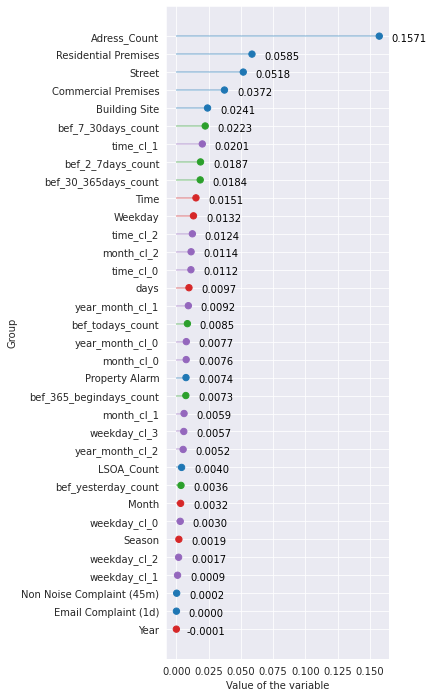

In [357]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(4, 12)) 
# Create a dataframe
df = importance_collection.loc[importance_collection.Type=='0-2 days'].reset_index()
 
# Reorder it based on values:
ordered_df = df.sort_values(by='Importance')
my_range=range(1,len(df.index)+1)
y_list = [*range(1,len(df.index)+1)]
y_list = list(reversed(y_list))
# Create a color if the group is "B"
my_color=np.where(ordered_df ['Feature'].isin(A), 'tab:blue', np.where(ordered_df ['Feature'].isin(B),'tab:red',np.where(ordered_df ['Feature'].isin(C),'tab:green','tab:purple')))
my_size=np.where(ordered_df ['Feature'].isin(A), 40, 40)
 
# The horizontal plot is made using the hline() function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Importance'], color=my_color, alpha=0.4)
plt.scatter(ordered_df['Importance'], my_range, color=my_color, s=my_size, alpha=1)
 
    
for i in range(len(df['Importance'])):
    label = "{:.4f}".format(df['Importance'][i])
    plt.annotate(str(label), # this is the text
                 (df['Importance'][i], y_list[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-5), # distance from text to points (x,y)
                 color = 'black',
                 ha='center') # horizontal alignment can be left, right or center  
    
    
# Add title and axis names
plt.yticks(my_range, ordered_df['Feature'])
#plt.title("What about the B group?", loc='left')
plt.xlabel('Value of the variable')
plt.ylabel('Group')

# show the graph
plt.show()

In [358]:
df = importance_collection.loc[importance_collection.Type=='0-2 days'].reset_index()
df

,index,Feature,Importance,Type
0,68,Adress_Count,0.157144,0-2 days
1,69,Residential Premises,0.058536,0-2 days
2,70,Street,0.051779,0-2 days
3,71,Commercial Premises,0.037208,0-2 days
4,72,Building Site,0.024099,0-2 days
5,73,bef_7_30days_count,0.022293,0-2 days
6,74,time_cl_1,0.020052,0-2 days
7,75,bef_2_7days_count,0.018651,0-2 days
8,76,bef_30_365days_count,0.018433,0-2 days
9,77,Time,0.015132,0-2 days


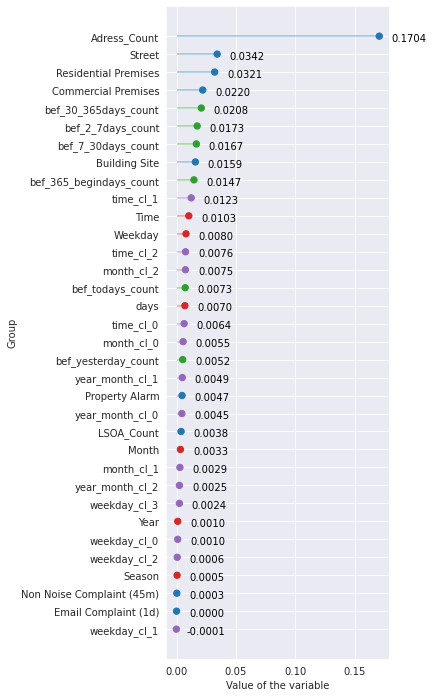

In [359]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(4, 12)) 
# Create a dataframe
df = importance_collection.loc[importance_collection.Type=='2-7 days'].reset_index()
 
# Reorder it based on values:
ordered_df = df.sort_values(by='Importance')
my_range=range(1,len(df.index)+1)
y_list = [*range(1,len(df.index)+1)]
y_list = list(reversed(y_list))
# Create a color if the group is "B"
my_color=np.where(ordered_df ['Feature'].isin(A), 'tab:blue', np.where(ordered_df ['Feature'].isin(B),'tab:red',np.where(ordered_df ['Feature'].isin(C),'tab:green','tab:purple')))
my_size=np.where(ordered_df ['Feature'].isin(A), 40, 40)
 
# The horizontal plot is made using the hline() function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Importance'], color=my_color, alpha=0.4)
plt.scatter(ordered_df['Importance'], my_range, color=my_color, s=my_size, alpha=1)
 
    
for i in range(len(df['Importance'])):
    label = "{:.4f}".format(df['Importance'][i])
    plt.annotate(str(label), # this is the text
                 (df['Importance'][i], y_list[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-5), # distance from text to points (x,y)
                 color = 'black',
                 ha='center') # horizontal alignment can be left, right or center  
    
    
# Add title and axis names
plt.yticks(my_range, ordered_df['Feature'])
#plt.title("What about the B group?", loc='left')
plt.xlabel('Value of the variable')
plt.ylabel('Group')

# show the graph
plt.show()

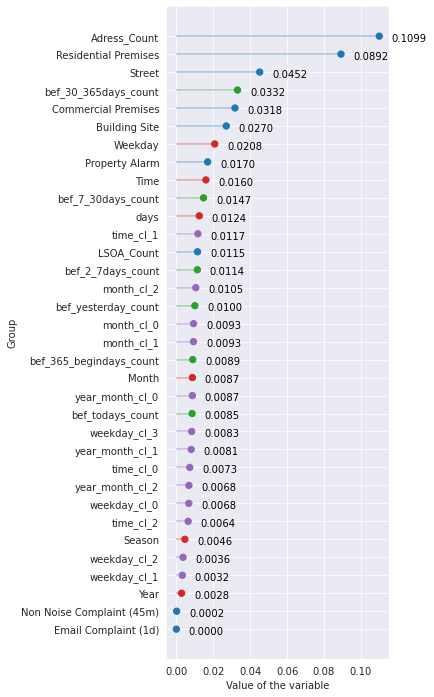

In [360]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(4, 12)) 
# Create a dataframe
df = importance_collection.loc[importance_collection.Type=='7-30 days'].reset_index()
 
# Reorder it based on values:
ordered_df = df.sort_values(by='Importance')
my_range=range(1,len(df.index)+1)
y_list = [*range(1,len(df.index)+1)]
y_list = list(reversed(y_list))
# Create a color if the group is "B"
my_color=np.where(ordered_df ['Feature'].isin(A), 'tab:blue', np.where(ordered_df ['Feature'].isin(B),'tab:red',np.where(ordered_df ['Feature'].isin(C),'tab:green','tab:purple')))
my_size=np.where(ordered_df ['Feature'].isin(A), 40, 40)
 
# The horizontal plot is made using the hline() function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Importance'], color=my_color, alpha=0.4)
plt.scatter(ordered_df['Importance'], my_range, color=my_color, s=my_size, alpha=1)
 
    
for i in range(len(df['Importance'])):
    label = "{:.4f}".format(df['Importance'][i])
    plt.annotate(str(label), # this is the text
                 (df['Importance'][i], y_list[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(30,-5), # distance from text to points (x,y)
                 color = 'black',
                 ha='center') # horizontal alignment can be left, right or center  
    
    
# Add title and axis names
plt.yticks(my_range, ordered_df['Feature'])
#plt.title("What about the B group?", loc='left')
plt.xlabel('Value of the variable')
plt.ylabel('Group')
#plt.legend(['A','B','C','D'])
# show the graph
plt.show()

In [362]:
from sklearn.ensemble import RandomForestClassifier
random_state_RF = 200
rf = RandomForestClassifier(random_state = random_state_RF)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 200,
 'verbose': 0,
 'warm_start': False}
